# Lab 2: Cats vs Dogs

**Deadline**: Out 04, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Martiya Zare Jahromi -- martiya.zare@mail.utoronto.ca

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link 

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/16akRTORsF_ZtsFRF7acIl0fbxsqPv58z/view?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

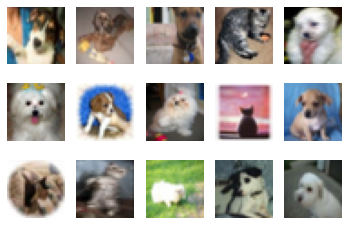

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [5]:
num_training_example = len(train_loader.dataset)
num_val_example = len(val_loader.dataset)
num_test_example = len(test_loader.dataset)
print("The number of training examples is " + str(num_training_example))
print("The number of validation examples is " + str(num_val_example))
print("The number of test examples is " + str(num_test_example))

The number of training examples is 50000
The number of validation examples is 50000
The number of test examples is 10000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [6]:
print("We need validation set to tune the parameters of a model, usually used for avoiding overfitting.")
print("As training set loss/error continues to decrease when we feed more data, if we purely judge the performance of models based on that, it's likely for us to overfit the model.")

We need validation set to tune the parameters of a model, usually used for avoiding overfitting.
As training set loss/error continues to decrease when we feed more data, if we purely judge the performance of models based on that, it's likely for us to overfit the model.


## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [7]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [9]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [10]:
num_small_net = 0
for param in small_net.parameters():
    print(param.shape)
    matrix_size = 1
    for dimension in param.shape:
      matrix_size *= dimension
    num_small_net += matrix_size
print("The total number of parameters in small_net is", str(num_small_net))

num_large_net = 0
for param in large_net.parameters():
    print(param.shape)
    matrix_size = 1
    for dimension in param.shape:
      matrix_size *= dimension
    num_large_net += matrix_size
print("The total number of parameters in large_net is", str(num_large_net))

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
The total number of parameters in small_net is 386
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
The total number of parameters in large_net is 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [11]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [12]:
print("The default value of batch_size is 64")
print("The default value of learning_rate is 0.01")
print("The default value of num_epochs is 30")

The default value of batch_size is 64
The default value of learning_rate is 0.01
The default value of num_epochs is 30


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [13]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=5)
print("================================================================================")
print("List of files written to disk: ")
print("1. model_small_bs64_lr0.01_epoch0: the trained model at epoch 0")
print("2. model_small_bs64_lr0.01_epoch1: the trained model at epoch 1")
print("3. model_small_bs64_lr0.01_epoch2: the trained model at epoch 2")
print("4. model_small_bs64_lr0.01_epoch3: the trained model at epoch 3")
print("5. model_small_bs64_lr0.01_epoch4: the trained model at epoch 4")
print("6. model_small_bs64_lr0.01_epoch4_train_err.csv: the training error at each epoch")
print("7. model_small_bs64_lr0.01_epoch4_train_loss.csv: the training loss at each epoch")
print("8. model_small_bs64_lr0.01_epoch4_val_err.csv: the validation error at each epoch")
print("9. model_small_bs64_lr0.01_epoch4_val_loss.csv: the validation loss at each epoch")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: Train err: 0.4225, Train loss: 0.673672287940979 |Validation err: 0.3825, Validation loss: 0.6579262502491474
Epoch 2: Train err: 0.364875, Train loss: 0.6461847257614136 |Validation err: 0.3705, Validation loss: 0.646935261785984
Epoch 3: Train err: 0.35325, Train loss: 0.6325755152702331 |Validation err: 0.347, Validation loss: 0.6277022864669561
Epoch 4: Train err: 0.33975, Train loss: 0.619905547618866 |Validation err: 0.3765, Validation loss: 0.6331371665000916
Epoch 5: Train err: 0.333125, Train loss: 0.6097778434753418 |Validation err: 0.3475, Validation loss: 0.6199892777949572
Finished Training
Total time elapsed: 19.37 seconds
List of files written to disk: 
1. model_small_bs64_lr0.01_epoch0: the trained model at epoch 0
2. model_small_bs64_lr0.01_epoch1: the trained model at epoch 1
3. model_small_bs64_lr0.01_epoch2: the trained model at epoch 2
4. model_small_bs64_lr0.01_epoch3: the trained model at epoch 3
5. model_small_bs64_lr0.01_epoch4: the trained model at ep

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [14]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)
# Total time elapsed for small_net is 102.13 seconds
# Total time elapsed for large_net is 114.50 seconds
# large_net took longer to train than small_net as it has more parameters.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.324375, Train loss: 0.6008213565349579 |Validation err: 0.336, Validation loss: 0.615692175924778
Epoch 2: Train err: 0.314, Train loss: 0.5950321021080017 |Validation err: 0.3245, Validation loss: 0.6125890146940947
Epoch 3: Train err: 0.317875, Train loss: 0.591228178024292 |Validation err: 0.337, Validation loss: 0.607023673132062
Epoch 4: Train err: 0.309125, Train loss: 0.5878902978897095 |Validation err: 0.3425, Validation loss: 0.6111240908503532
Epoch 5: Train err: 0.3005, Train loss: 0.5800716781616211 |Validation err: 0.3225, Validation loss: 0.6006949227303267
Epoch 6: Train err: 0.29925, Train loss: 0.5745266406536103 |Validation err: 0.322, Validation loss: 0.6065836464986205
Epoch 7: Train err: 0.300625, Train loss: 0.5745934362411499 |Validation err: 0.326, Validation loss: 0.596733694896102
Epoch 8: Train err: 0.293625, Train loss: 0.5671015388965607 |Validation err: 0.3185

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

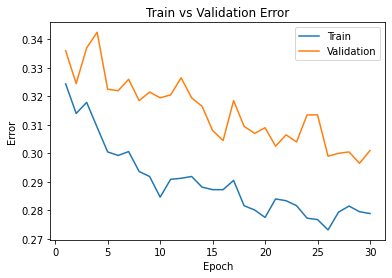

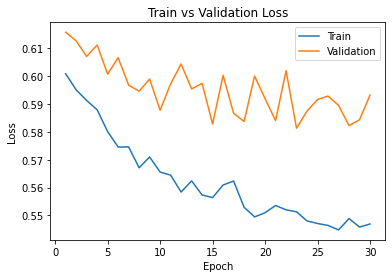

In [16]:
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)

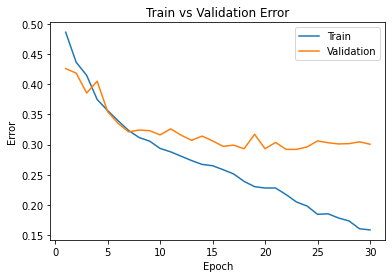

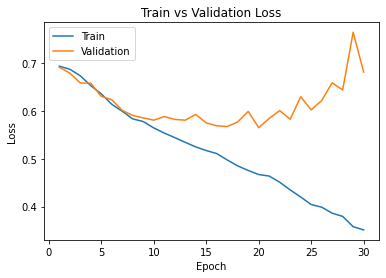

In [17]:
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [19]:
# For small_net, as epoch number goes up, both training loss and training error go down in general. 
# While, the validation loss and validation error go down as epoch number goes up at first, and then they just fluctuant without obvious trend of increase or decrease.

# For large_net, as epoch number goes up, both training loss and training error decrease. 
# On the other hand, as epoch number goes up, validation error decreases at first and then flactuants around 0.3, and validation loss decreses first and then increases.

# The curve for small_net fluctuant more and large_net, and it's more easy to recognize a general trend for large_net.

# The small_net case is always underfitting, while large_net is underfitting when epoch number is small(than 5)， and it's overfitting when epoch number is big(than 10).

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

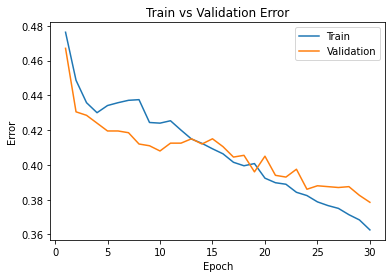

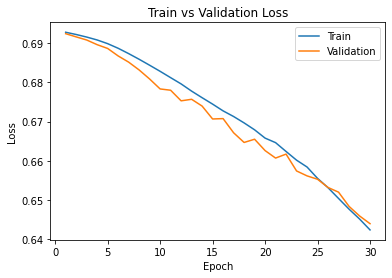

In [20]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

# The 0.001 learning rate model took 113.64 seconds and the 0.01 learning rate model took 114.50 seconds. They took about the same time to train.

# By lowering the learning rate, the model doesn't overfit when learning rate lowers from 0.01 to 0.01. 
# However, the error and loss for train and validation both went up.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

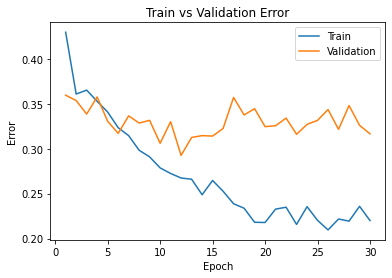

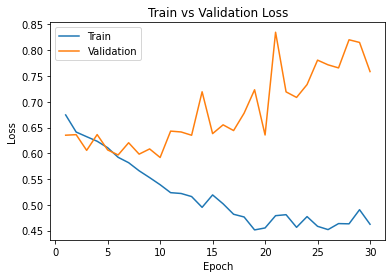

In [30]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large)

# By increasing the learning rate to 0.1, the training time didn't change a lot.
# The error and loss are roughly the same as before, but the validation loss is higher in general.
# And overfitting still occurs for both error and loss function.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

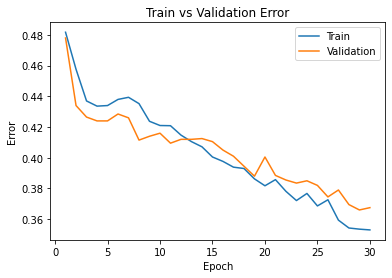

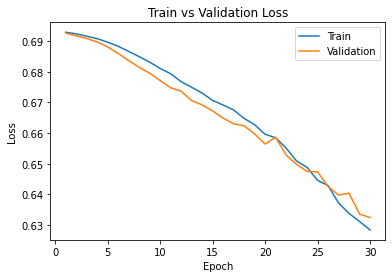

In [29]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

# By increasing the batch size, the model is no longer overfitting and the training time is shorter.
# The train and validation error and loss are roughly the same, and the range is smaller than before.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

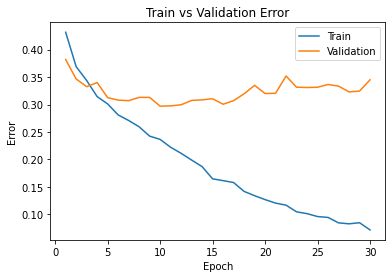

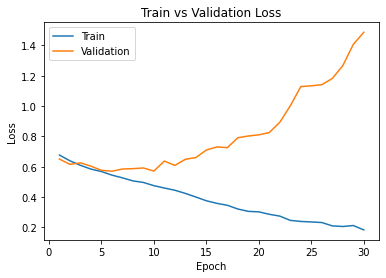

In [28]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)
model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

# By lowering the batch size, the training time increases significantly.
# All error and loss stay roughly the same, except of validation loss , which increases significantly.
# And the model also overfit over all epoch number.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [31]:
# (large_net, batch_size=512, learning_rate=0.001, num_epochs=30)
# Because in the test above increasing batch size and lowering learning rate both can eliminate overfitting problem. And increasing batch size can also shorten training time.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280497133732 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808391094208 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435550510883 |Validation err: 0.463, Va

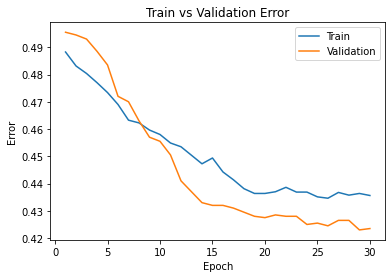

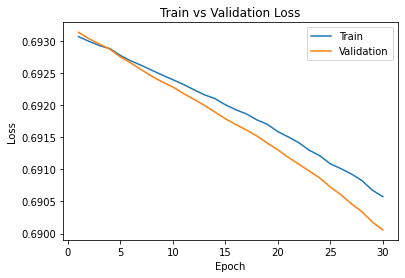

In [32]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs=30)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [51]:
# (large_net, batch_size=256, learning_rate=0.01, num_epochs=30)
# Because Part 4 - part b model is not as good(overfit and error/loss value bigger) as Part 3 - part d, so I increase the learning rate to 0.01 again, and bring up batch size to see if this combination can perform better.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.501625, Train loss: 0.6934147235006094 |Validation err: 0.493, Validation loss: 0.6926314979791641
Epoch 2: Train err: 0.492625, Train loss: 0.6926321033388376 |Validation err: 0.4705, Validation loss: 0.692109577357769
Epoch 3: Train err: 0.443, Train loss: 0.6920247599482536 |Validation err: 0.403, Validation loss: 0.6914891228079796
Epoch 4: Train err: 0.419375, Train loss: 0.691142650321126 |Validation err: 0.403, Validation loss: 0.6901652738451958
Epoch 5: Train err: 0.433375, Train loss: 0.6898066829890013 |Validation err: 0.427, Validation loss: 0.6879258900880814
Epoch 6: Train err: 0.418125, Train loss: 0.6875213254243135 |Validation err: 0.415, Validation loss: 0.6842162385582924
Epoch 7: Train err: 0.421125, Train loss: 0.6838985830545425 |Validation err: 0.4095, Validation loss: 0.6786788403987885
Epoch 8: Train err: 0.409875, Train loss: 0.679199181497097 |Validation err: 0.4

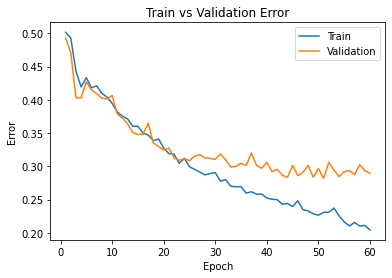

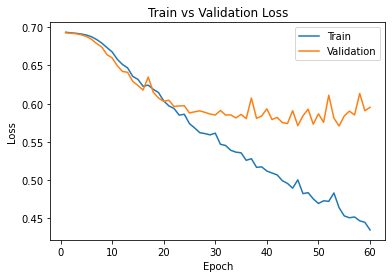

In [43]:
large_net = LargeNet()
train_net(large_net, batch_size=256, learning_rate=0.01, num_epochs=60)
model_path_large = get_model_name("large", batch_size=256, learning_rate=0.01, epoch=59)
plot_training_curve(model_path_large)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6932549700140953 |Validation err: 0.509, Validation loss: 0.693367063999176
Epoch 2: Train err: 0.495625, Train loss: 0.6930654775351286 |Validation err: 0.479, Validation loss: 0.6929256394505501
Epoch 3: Train err: 0.494625, Train loss: 0.692832387983799 |Validation err: 0.505, Validation loss: 0.6927450224757195
Epoch 4: Train err: 0.49475, Train loss: 0.6924449298530817 |Validation err: 0.4705, Validation loss: 0.6922403052449226
Epoch 5: Train err: 0.472, Train loss: 0.6917294133454561 |Validation err: 0.444, Validation loss: 0.6912434846162796
Epoch 6: Train err: 0.467875, Train loss: 0.6908945739269257 |Validation err: 0.4425, Validation loss: 0.6898156702518463
Epoch 7: Train err: 0.4535, Train loss: 0.6892077457159758 |Validation err: 0.435, Validation loss: 0.687789723277092
Epoch 8: Train err: 0.442875, Train loss: 0.686610471457243 |Validation err: 0.4295, 

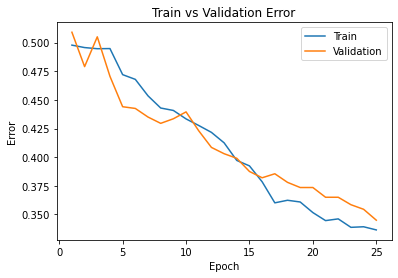

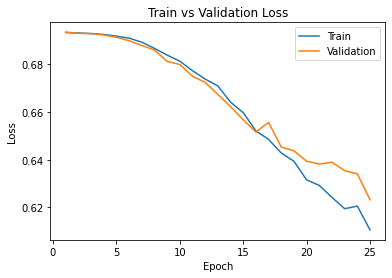

<All keys matched successfully>

In [52]:
net = LargeNet()
train_net(net, batch_size=256, learning_rate=0.01, num_epochs=25)
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.01, epoch=24)
plot_training_curve(model_path)
state = torch.load(model_path)
net.load_state_dict(state)

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# The best model I can get is the model in part (a) above
# (large_net, batch_size=256, learning_rate=0.01, epochs=25): 
# Train err: 0.3365, Train loss: 0.6105825025588274 |Validation err: 0.345, Validation loss: 0.6232095509767532
# At the epoch number, the model does not overfit and the error and loss values for training and validation are relatively low and compared to other models.
# Also, the validation and train values do not varies a lot from each other, and the model does not fluctuate a lot.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [44]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

test_error, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("The test classification error is", test_error)
val_error, val_loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())
print("The validation error is", val_error)

Files already downloaded and verified
Files already downloaded and verified
The test classification error is 0.3735
The validation error is 0.366


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [45]:
# The test classification error is slightly larger than the validation error
# Because validation data is seen before by the model, but the test data is not.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# Because test data is used to test our model after training and validation process. 
# We want to leave it at the very end, because we want to test how well our model react to new data that never seen before. 
# And that's also why we don't want to use them before testing phase (keep them new to the model).
# In addition, we should only leave enough data for testing, because we don't want to lack data in training and validation phases.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.414125, Train loss: 0.6636841769218444 |Validation err: 0.393, Validation loss: 0.6507337633520365
Epoch 2: Train err: 0.373875, Train loss: 0.638375207901001 |Validation err: 0.392, Validation loss: 0.6578669100999832
Epoch 3: Train err: 0.35625, Train loss: 0.6271215128898621 |Validation err: 0.3755, Validation loss: 0.6445923913270235
Epoch 4: Train err: 0.34275, Train loss: 0.615827835559845 |Validation err: 0.397, Validation loss: 0.6674672402441502
Epoch 5: Train err: 0.327, Train loss: 0.6033829712867737 |Validation err: 0.3835, Validation loss: 0.6477418579161167
Epoch 6: Train err: 0.310375, Train loss: 0.5885210726261139 |Validation err: 0.3745, Validation loss: 0.6543322373181581
Epoch 7: Train err: 0.302625, Train loss: 0.5773693723678589 |Validation err: 0.3865, Validation loss: 0.6594872232526541
Epoch 8: Train err: 0.29025, Train loss: 0.5601859123706817 |Validation err: 0.3

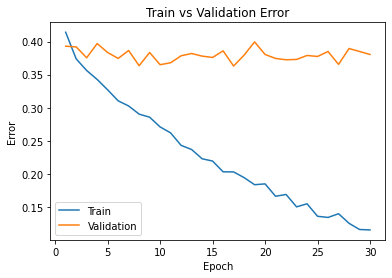

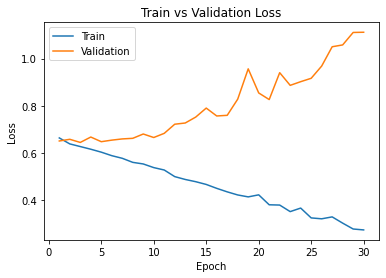

Files already downloaded and verified
Files already downloaded and verified
The test classification error is 0.3735


In [50]:
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(3 * 32 * 32, 30)
        self.layer2 = nn.Linear(30, 1)
        self.name = "pigeon"

    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2



pigeon = Pigeon()
train_net(pigeon, batch_size=64, learning_rate=0.01, num_epochs=30)
model_path_pigeon = get_model_name("pigeon", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_pigeon)
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64) # One image per batch
test_error, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("The test classification error is", test_error)

the test classification error i get for the ANN model is 0.3735, which is larger than CNN model
